   unit  cycle  setting1  setting2  setting3      s1      s2       s3  \
0     1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1     1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2     1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3     1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4     1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   

        s4     s5  ...      s13      s14     s15   s16  s17   s18    s19  \
0  1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  RUL  
0  39.06  23.4190  125  
1  39.00  23.4236  125  
2  38.95  23.3442  125  
3  3

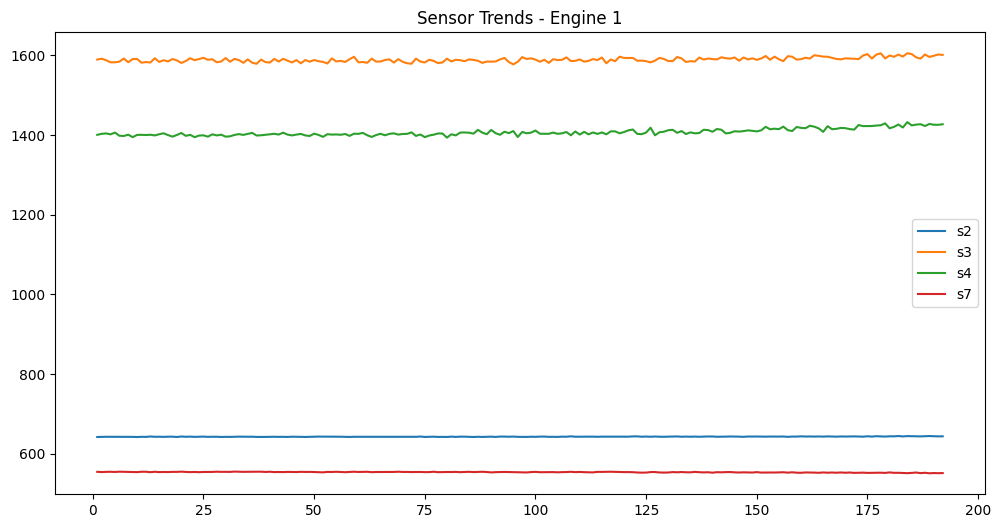

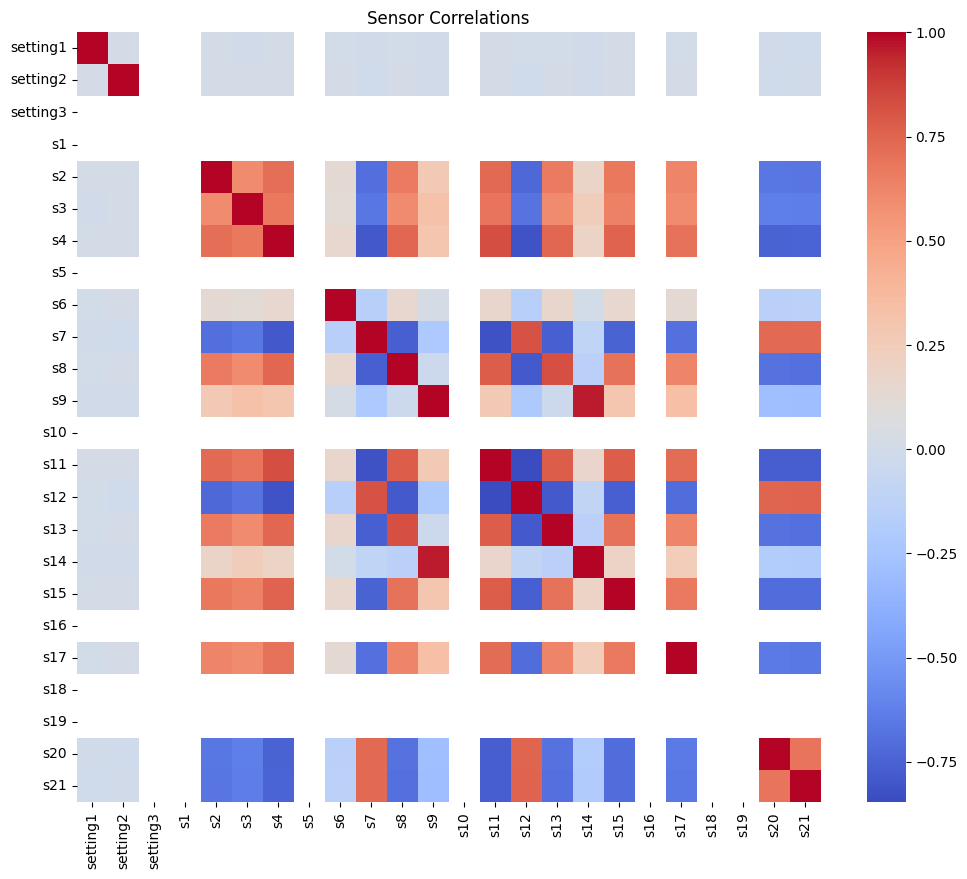

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load data (adjust path)
def load_data(file_path, is_train=True):
    columns = ['unit', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
    df = pd.read_csv(file_path, sep=' ', header=None, names=columns, usecols=range(26))  # drop NaN cols
    return df

train = load_data('train_FD001.txt')
test = load_data('test_FD001.txt')
rul_test = pd.read_csv('RUL_FD001.txt', header=None, names=['RUL'])

# Step 2: Add RUL to train (linear, but cap at 125-130 for early stability)
train['RUL'] = train.groupby('unit')['cycle'].transform(lambda x: x.max() - x)
train['RUL'] = np.minimum(train['RUL'], 125)  # Piecewise linear common trick

# Test RUL is only for last cycle per engine → we'll predict per engine's last window

# Step 3: EDA quick views
print(train.head())
print(f"Number of engines: {train['unit'].nunique()}")
print(f"Max cycles per engine: {train.groupby('unit')['cycle'].max().describe()}")

# Plot one engine's sensors
engine1 = train[train['unit'] == 1]
plt.figure(figsize=(12,6))
for col in ['s2', 's3', 's4', 's7']:  # good degrading sensors
    plt.plot(engine1['cycle'], engine1[col], label=col)
plt.legend()
plt.title('Sensor Trends - Engine 1')
plt.show()

# Correlation heatmap (drop constants first)
corr = train.drop(['unit', 'cycle', 'RUL'], axis=1).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Sensor Correlations')
plt.show()

# Drop useless sensors (low variance or constant, e.g., s1, s5, s10, s16, s18, s19 often)
drop_sensors = ['s1','s5','s10','s16','s18','s19']  # common choices from EDA
train = train.drop(drop_sensors + ['setting3'], axis=1)  # setting3 often constant
test = test.drop(drop_sensors + ['setting3'], axis=1)

In [ ]:
# After dropping useless columns (you already have this)
drop_sensors = ['s1', 's5', 's10', 's16', 's18', 's19']
drop_cols = drop_sensors + ['setting3']  # setting3 is often constant

# Create list of feature columns explicitly (the ones we actually scale)
feature_cols = [col for col in train.columns if col not in ['unit', 'cycle', 'RUL'] + drop_cols]

print("Feature columns we will scale:", feature_cols)
print("Number of features:", len(feature_cols))  # Should print 17

# Scale ONLY the feature columns
scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])   # assuming test also dropped same cols

# Now NO NEED to create train_scaled_df separately for scaling
# train already has scaled features + unit/cycle/RUL

# Proceed directly to sequence creation
# (Your create_sequences function expects df with unit, cycle, RUL, and scaled features)
X_train, y_train = create_sequences(train, sequence_length)

# For test (similar logic, but no RUL)
# ...

Feature columns we will scale: ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
Number of features: 17


In [ ]:
# Define feature columns explicitly (from your print output)
feature_cols = [
    'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9',
    's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'
]

# Scale only these columns
scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])

# Apply same scaler to test (after dropping the same columns on test!)
test[feature_cols] = scaler.transform(test[feature_cols])

# Optional: Save scaler for dashboard later
import joblib
joblib.dump(scaler, 'scaler.pkl')

print("Scaling done! Sample of scaled train:")
print(train[feature_cols + ['unit', 'cycle', 'RUL']].head())

Scaling done! Sample of scaled train:
   setting1  setting2        s2        s3        s4   s6        s7        s8  \
0  0.459770  0.166667  0.183735  0.406802  0.309757  1.0  0.726248  0.242424   
1  0.609195  0.250000  0.283133  0.453019  0.352633  1.0  0.628019  0.212121   
2  0.252874  0.750000  0.343373  0.369523  0.370527  1.0  0.710145  0.272727   
3  0.540230  0.500000  0.343373  0.256159  0.331195  1.0  0.740741  0.318182   
4  0.390805  0.333333  0.349398  0.257467  0.404625  1.0  0.668277  0.242424   

         s9       s11       s12       s13       s14       s15       s17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

        s20       s21  unit  c

In [ ]:
sequence_length = 30  # or 50, 100 — experiment later

X_train, y_train = create_sequences(train, sequence_length)

print("X_train shape:", X_train.shape)          # Should be (num_samples, 30, 17)
print("y_train shape:", y_train.shape)          # (num_samples,)

X_train shape: (17631, 30, 17)
y_train shape: (17631,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Quick save for dashboard
model.save('best_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 6680.9653 - val_loss: 5662.2070
Epoch 2/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 4759.2827 - val_loss: 4260.4170
Epoch 3/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 3530.2124 - val_loss: 3289.7859
Epoch 4/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 2782.4390 - val_loss: 2651.0247
Epoch 5/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 2289.4055 - val_loss: 2251.2905
Epoch 6/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 2020.8060 - val_loss: 2021.7761
Epoch 7/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 1875.2468 - val_loss: 1902.7202
Epoch 8/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 1803.8608 - val_loss: 1845.5487
Epoch 9/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 1766.4399 - val_loss: 1820.0486
Epoch 10/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 1787.5367 - val_loss: 1808.1171
Epoch 11/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 22s 35m

In [ ]:
import numpy as np

# Make sure these are defined from earlier:
# - test: the loaded & processed test_FD001.txt DataFrame
# - feature_cols: your list of 17 scaled features
# - sequence_length: e.g. 30 (must match what you used in training!)

# If you haven't scaled test yet — do it here (should already be done, but safe)
# scaler.transform(test[feature_cols])   ← run if needed

def create_test_sequences(df, seq_len, feature_cols):
    X = []
    grouped = df.groupby('unit')
    for unit_id, group in grouped:
        data = group[feature_cols].values  # only the scaled feature columns
        if len(data) < seq_len:
            # Simple zero-padding for short engines (rare in FD001 test)
            pad = np.zeros((seq_len - len(data), len(feature_cols)))
            seq = np.vstack([pad, data])
        else:
            seq = data[-seq_len:]  # take the last seq_len timesteps
        X.append(seq)
    return np.array(X)

# Create X_test
sequence_length = 30  # ← CHANGE THIS if you used a different value during training!
X_test = create_test_sequences(test, sequence_length, feature_cols)

print("X_test shape:", X_test.shape)          # Should be (100, 30, 17) for FD001
print("Number of test engines:", len(X_test))

X_test shape: (100, 30, 17)
Number of test engines: 100


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
Test RMSE: 14.61 cycles
Test MAE:  11.06 cycles
NASA Score: 355.13 (lower is better)


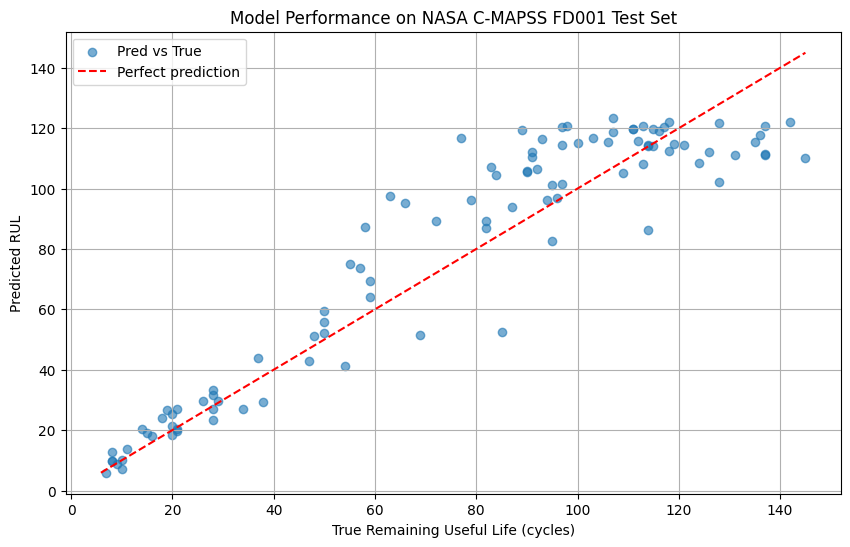

Predictions saved to 'test_predictions.csv'


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load (you can keep using .h5 or switch to .keras)
model = load_model('best_model.h5', custom_objects={'mse': MeanSquaredError()})
# Or if you already resaved: model = load_model('best_model.keras')

# Predict
preds = model.predict(X_test).flatten()

# True RUL (make sure rul_test is loaded!)
# If not loaded yet, add:
# rul_test = pd.read_csv('RUL_FD001.txt', header=None, names=['RUL'])
y_test = rul_test['RUL'].values

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

def nasa_score(y_true, y_pred):
    d = y_pred - y_true
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

score = nasa_score(y_test, preds)

print(f"Test RMSE: {rmse:.2f} cycles")
print(f"Test MAE:  {mae:.2f} cycles")
print(f"NASA Score: {score:.2f} (lower is better)")

# Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, preds, alpha=0.6, label='Pred vs True')
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
plt.xlabel('True Remaining Useful Life (cycles)')
plt.ylabel('Predicted RUL')
plt.title('Model Performance on NASA C-MAPSS FD001 Test Set')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Save predictions for later/report
results = pd.DataFrame({'True_RUL': y_test, 'Predicted_RUL': preds})
results.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'")